In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
# import disk from skimage

from skimage.draw import disk
from scipy.ndimage import convolve
from matplotlib.animation import FuncAnimation

import matplotlib.animation as animation
from tqdm.notebook import tqdm, trange

from scipy.ndimage import binary_dilation

## PATHS and CONSTANTS



In [3]:
PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#movie = 'Control'
#movie = '130721'
#movie ='140721'
#movie ='150721'
#movie ='100621'
movie ='130721_CCA60_RAW'
#movie ='280523 AM100 568'
ADD_PATH = os.path.join(PROJECT_PATH, "add_data/", movie + "/")


MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'

In [4]:
spike = np.load(MOVIE_PATH + 'np/spike.npy').astype(np.float32)

# <span style="color:red">Smoothing spike</span>

In [5]:
import numpy as np
from skimage.filters import gaussian
from scipy.interpolate import griddata
from tqdm.notebook import trange, tqdm
sigma = 5
# Assuming your array is named 'spike'
smoothed_spike = np.empty_like(spike)

# Iterating over the time axis
for t in trange(spike.shape[0]):
    image = spike[t]

    # Create a mask of NaN locations
    mask = np.isnan(image)

    # Coordinates of non-NaN values
    coords = np.array(np.where(~mask)).T
    values = image[~mask]

    # Coordinates of NaN values
    nan_coords = np.array(np.where(mask)).T

    # Interpolate the NaN values
    interpolated_values = griddata(coords, values, nan_coords, method='linear')

    # Place interpolated values into the image
    image[mask] = interpolated_values

    # Apply Gaussian filter to the interpolated image
    smoothed_spike[t] = gaussian(image, sigma=sigma)  # Change sigma for desired level of blurring
    smoothed_spike[t][mask] = np.nan  # Replace NaN values



  0%|          | 0/62 [00:00<?, ?it/s]

In [22]:
np.save(MOVIE_PATH + 'tmp/smoothed_spike.npy', smoothed_spike)

In [10]:
smoothed_spike = np.load(MOVIE_PATH + 'tmp/smoothed_spike.npy')

#<span style="color:red">CUrvature with soble filter</span>

In [5]:

from  utils.graph_utils import values_3d as values_3d
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy', mmap_mode='r')

intensity = values_3d(gel, smoothed_spike)


hi


In [49]:
t = 10
max_r  = 200
intensity_2d = intensity[t]
third_r = intensity_2d.shape[0]//3
center = (intensity_2d.shape[0]//2, intensity_2d.shape[1]//2)
def draw_ring(outer_radius, inner_radius):
    rr_outer, cc_outer = disk((outer_radius, outer_radius), outer_radius)
    rr_inner, cc_inner = disk((outer_radius, outer_radius), inner_radius)
    ring = np.zeros((outer_radius*2,outer_radius*2))
    ring[rr_outer, cc_outer] = 1
    ring[rr_inner, cc_inner] = 0
    ring= ring/np.sum(ring)
    return ring
distribution = np.zeros((intensity.shape[0], max_r, intensity.shape[1], intensity.shape[2]))

for t in tqdm([15,19,20,30]):
    intensity_2d = intensity[t]
    intensity_2d[np.isnan(intensity_2d)] = np.nanmean(intensity_2d)
    for r in range(2,max_r):
        r_ring  = draw_ring(r, r-1)
        distribution[t,r] = convolve(intensity_2d, r_ring)
    np.save(MOVIE_PATH + 'tmp/distribution%d.npy'%t, distribution[t])    


  0%|          | 0/4 [00:00<?, ?it/s]

In [80]:
distribution = np.zeros((intensity.shape[0], max_r, intensity.shape[1], intensity.shape[2]))
for t in trange(62):
    distribution[t] = np.load(MOVIE_PATH + 'tmp/distribution_full%d.npy'%t)
np.save(MOVIE_PATH + 'tmp/distribution_full.npy', distribution)
    

  0%|          | 0/62 [00:00<?, ?it/s]

In [76]:
distribution_plot= []
for t in trange(60):
    distribution = np.load(MOVIE_PATH + 'tmp/distribution_full%d.npy'%t)
    disc = disk((256, 256), 20)
    mask = np.zeros_like(intensity_2d)
    mask[disc] = 1
    masked_distribution = distribution.copy()
    for r in range(len(distribution)):
        masked_distribution[r][mask == 0] = np.nan
        
    mean_distribution = np.nanmean(masked_distribution, axis = (1,2))
    #plt.plot(mean_distribution[2:max_r])
    #plt.show()
    distribution_plot.append(mean_distribution/(np.nansum(intensity[t])/(intensity.shape[1]*intensity.shape[2])))
    


  0%|          | 0/60 [00:00<?, ?it/s]

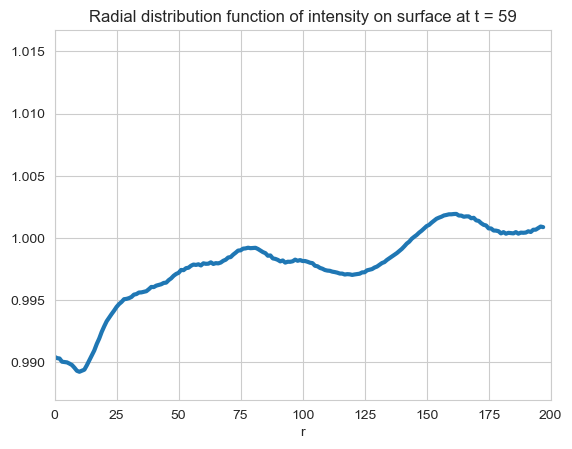

In [79]:
fig, ax = plt.subplots()
distribution_plot = np.array(distribution_plot)
# Initializing a line plot. xdata and ydata are set to empty lists initially.
line, = plt.plot([], [], lw=3)

def init():
    ax.set_xlim(0, len(distribution_plot[0]-2))
    ax.set_ylim(np.min(distribution_plot[:,2:]), np.max(distribution_plot[:,2:]))
    return line,


def update(frame):
    ax.set_title('Radial distribution function of intensity on surface at t = %d'%frame)
    ax.set_xlabel('r')
    ydata = distribution_plot[frame][2:]
    xdata = np.arange(len(ydata))
    line.set_data(xdata, ydata)
    return line,

ani = FuncAnimation(fig, update, frames=range(len(distribution_plot)), init_func=init, blit=True, interval=1000)


ani.save(GRAPH_PATH + 'distribution/%s.mp4'%movie, writer='ffmpeg', fps=1)


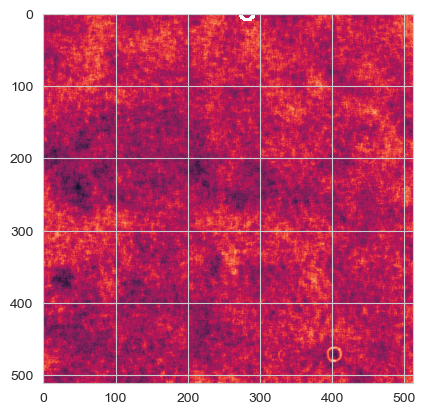

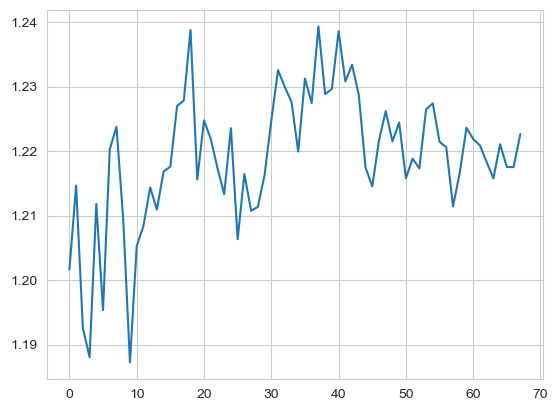

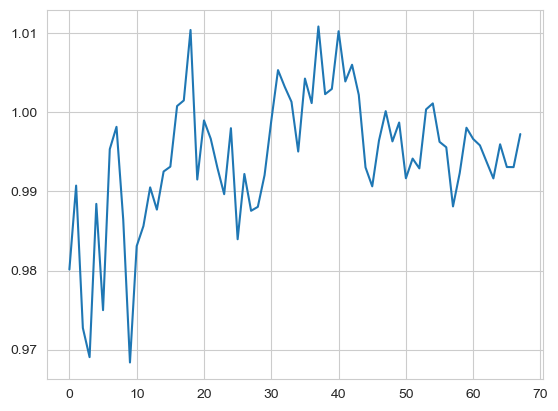

In [19]:
plt.imshow(distribution[10])
plt.show()
radial_function = distribution[2:70,center[0], center[1]]
plt.plot(radial_function)
plt.show()
radial_function_normalized = radial_function/(np.nansum(intensity_2d)/(intensity_2d.shape[0]*intensity_2d.shape[1]))   
plt.plot(radial_function_normalized)
plt.show()


In [20]:
print(np.sum(np.isnan(spike[10])))

3


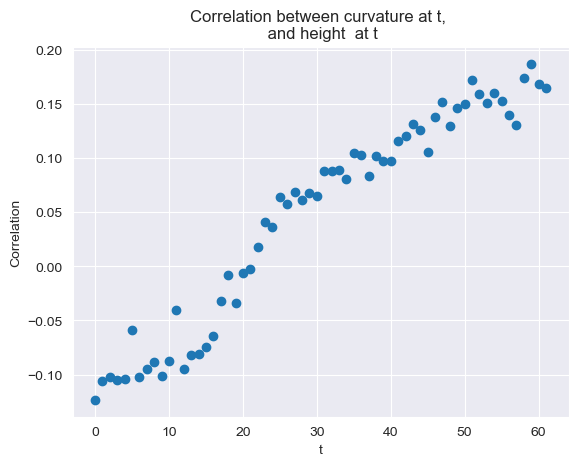

In [15]:
plt.scatter(t_list,c)
plt.title('Correlation between curvature at t, \n and height  at t')
plt.xlabel('t')
plt.ylabel('Correlation')
plt.show()


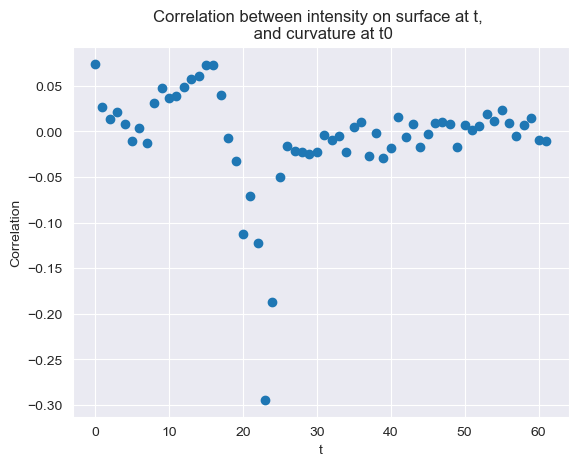

In [8]:
plt.scatter(t_list,i_list)
plt.title('Correlation between intensity on surface at t, \n and curvature at t0')
plt.xlabel('t')
plt.ylabel('Correlation')
plt.show()


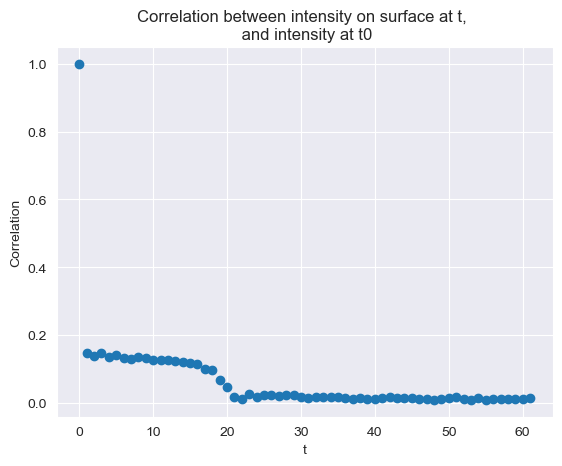

In [12]:
plt.scatter(t_list,ii_list)
plt.title('Correlation between intensity on surface at t, \n and intensity at t0')
plt.xlabel('t')
plt.ylabel('Correlation')
plt.show()


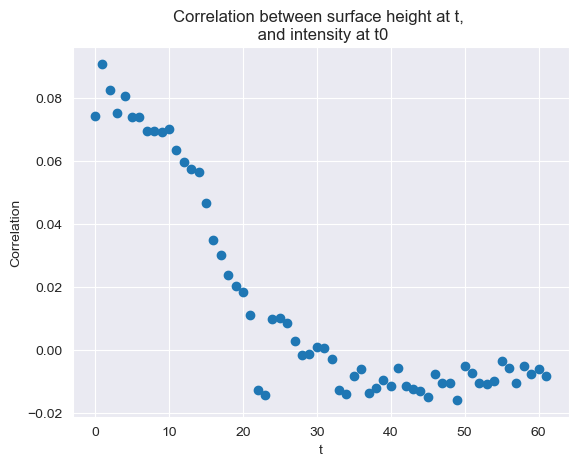

In [14]:
plt.scatter(t_list,i0ht_list)
plt.title('Correlation between surface height at t, \n and intensity at t0')
plt.xlabel('t')
plt.ylabel('Correlation')
plt.show()


In [9]:
np.save(MOVIE_PATH + 'tmp/intensity.npy', intensity)
np.save(MOVIE_PATH + 'tmp/curvature.npy', curvature)

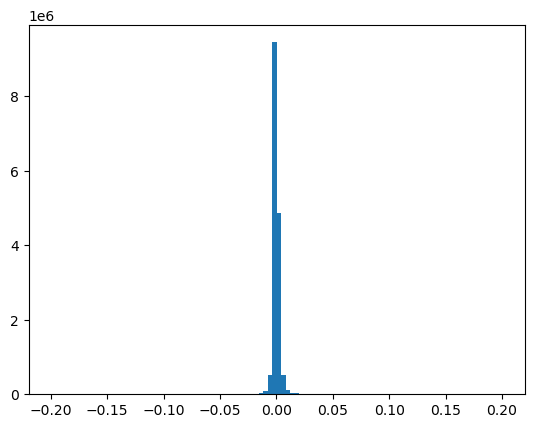

In [10]:
tmp = curvature[abs(curvature)< 0.2 ]
plt.hist(tmp.flatten(), bins = 100)
plt.show()


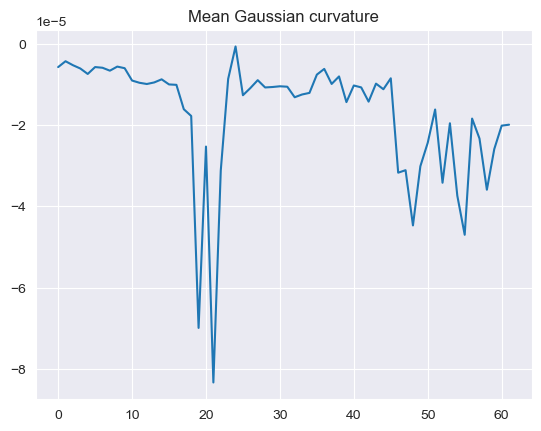

In [10]:
mean_curvature = np.nanmean(curvature, axis = (1,2))
plt.plot(mean_curvature)
plt.title('Mean Gaussian curvature')
plt.show()


In [17]:
import numpy as np
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import LinearColorMapper, Slider
from bokeh.layouts import column
from bokeh.palettes import Viridis256
from bokeh.transform import transform
from bokeh.models.sources import ColumnDataSource
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

output_notebook()

def modify_doc(doc):
    # Example 3D data
    data_3d = curvature  # Replace this with your 3D array

    # Create ColumnDataSource
    source = ColumnDataSource(data={'image': [data_3d[0,:, :]]})

    # Set up plot
    p = figure(width=500, height=500, x_range=(0, 10), y_range=(0, 10), title="Animated 3D Array")
    p.image(image='image', x=0, y=0, dw=10, dh=10, source=source, color_mapper=LinearColorMapper(palette=Viridis256))

    # Set up slider
    slider = Slider(start=0, end=data_3d.shape[0]-1, value=0, step=1, title="Index")

    # Update function
    def update(attr, old, new):
        source.data = {'image': [data_3d[slider.value,:, :]]}

    slider.on_change('value', update)

    # Organize layout
    layout = column(p, slider)

    # Add to doc
    doc.add_root(layout)

handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)


Loading BokehJS ...